<h1>Table of Contents &lt;br&gt;&lt;/br&gt;<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Bulk-Data-Merit-Order" data-toc-modified-id="Bulk-Data-Merit-Order-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Bulk Data Merit Order</a></span><ul class="toc-item"><li><span><a href="#List-of-Tenders-(Ausschreibung)" data-toc-modified-id="List-of-Tenders-(Ausschreibung)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>List of Tenders (Ausschreibung)</a></span></li><li><span><a href="#Result-of-Tenders-(Abgegebene-Angebote-/-Allocated-SRL)" data-toc-modified-id="Result-of-Tenders-(Abgegebene-Angebote-/-Allocated-SRL)-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Result of Tenders (Abgegebene Angebote / Allocated SRL)</a></span><ul class="toc-item"><li><span><a href="#Supply/Demand-Curve-according-to-bids-and-asks-(According-to-Kahlen)" data-toc-modified-id="Supply/Demand-Curve-according-to-bids-and-asks-(According-to-Kahlen)-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Supply/Demand Curve according to bids and asks (According to Kahlen)</a></span></li></ul></li><li><span><a href="#Activated-Control-Reserve-regelleistungen.net" data-toc-modified-id="Activated-Control-Reserve-regelleistungen.net-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Activated Control Reserve regelleistungen.net</a></span><ul class="toc-item"><li><span><a href="#Weekly-activated-secondary-control-reserve" data-toc-modified-id="Weekly-activated-secondary-control-reserve-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Weekly activated secondary control reserve</a></span></li></ul></li><li><span><a href="#Double-Check-Numbers" data-toc-modified-id="Double-Check-Numbers-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Double Check Numbers</a></span></li></ul></li><li><span><a href="#Calculate-Merit-order-for-each-Week" data-toc-modified-id="Calculate-Merit-order-for-each-Week-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Calculate Merit order for each Week</a></span></li></ul></div>

In [2]:
# Display plots inline
%matplotlib inline

# Autoreload all package before excecuting a call
%load_ext autoreload
%autoreload 2

In [3]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Bulk Data Merit Order

## List of Tenders (Ausschreibung)

In [4]:
df_tenders = pd.read_csv("../data/raw/balancing/tenders_2016_2017.csv", sep=';', index_col=False,
                     dayfirst=True, parse_dates=[0, 1, 2, 3,4], infer_datetime_format=True, decimal=',')
df_tenders = df_tenders[['DATE_FROM', 'DATE_TO', 'GATE_OPEN_TIME', 'GATE_COSURE_TIME', 'PRODUCT', 'TOTAL_DEMAND_[MW]']]
df_tenders.columns = ['from', 'to', 'gate_opening', 'gate_closure', 'product', 'demand_mw'] df_tenders.head(20)

SyntaxError: invalid syntax (<ipython-input-4-5748e94be126>, line 4)

## Result of Tenders (Abgegebene Angebote / Allocated SRL)

Double checked with e.g. 
- https://www.smard.de/blueprint/servlet/page/home/marktdaten/78?marketDataAttributes=%7B%22resolution%22:%22week%22,%22region%22:%22DE%22,%22from%22:1509490800000,%22to%22:1512945900000,%22moduleIds%22:%5B18000422,18000423%5D,%22selectedCategory%22:null,%22activeChart%22:true,%22language%22:%22de%22%7D#chart-legend

**Caution: When aggregating take into account not to sum up HT and NT!**

In [5]:
df_results = pd.read_csv("../data/raw/balancing/results_2016_2017.csv", sep=';', index_col=False,
                     dayfirst=True, parse_dates=[0, 1], infer_datetime_format=True, decimal=',')

df_results.drop(['TYPE_OF_RESERVES', 'COUNTRY'], inplace=True, axis=1)
df_results.columns = ['from', 'to', 'product', 'capacity_price_mw','energy_price_mwh', 'payment_direction', 'offered_mw', 'allocated_mw']

df_results = pd.concat([df_results, pd.DataFrame(df_results["product"].str.split('_',1).tolist(),
                                   columns = ['product_type','product_time'])], axis = 1)
df_results.drop('product', axis=1, inplace=True)

In [6]:
# Check for negative payment direction in positive control reserve
df_results.loc[df_results["product_type"] == "POS"]["payment_direction"].unique()

array(['GRID_TO_PROVIDER'], dtype=object)

In [7]:
# Make energy prices negative where provider has to pay for energy
df_results.loc[df_results['payment_direction'] == 'PROVIDER_TO_GRID',['energy_price_mwh']] = df_results['energy_price_mwh'] * (-1)
df_results.drop(["payment_direction"], axis=1, inplace=True)
df_results.sort_values(['from', 'product_type', 'product_time', 'energy_price_mwh'])

,from,to,capacity_price_mw,energy_price_mwh,offered_mw,allocated_mw,product_type,product_time
123,2015-12-28,2016-01-03,633.00,-1.00,5,5,NEG,HT
106,2015-12-28,2016-01-03,504.00,0.50,10,10,NEG,HT
126,2015-12-28,2016-01-03,643.00,4.00,12,12,NEG,HT
107,2015-12-28,2016-01-03,520.00,5.90,10,10,NEG,HT
110,2015-12-28,2016-01-03,567.00,5.90,20,20,NEG,HT
111,2015-12-28,2016-01-03,583.00,5.90,20,20,NEG,HT
113,2015-12-28,2016-01-03,615.00,5.90,20,20,NEG,HT
10,2015-12-28,2016-01-03,499.00,6.50,10,10,NEG,HT
112,2015-12-28,2016-01-03,599.00,7.50,20,20,NEG,HT
127,2015-12-28,2016-01-03,653.00,8.00,12,12,NEG,HT


### Supply/Demand Curve according to bids and asks (According to Kahlen)

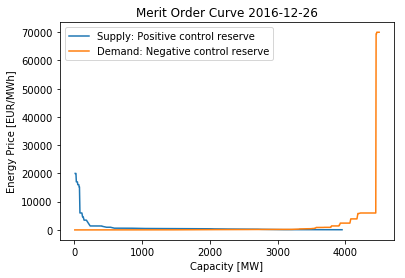

Clearing Price: 143.0 EUR/MWh


In [33]:
time = "HT"
day = "2016-12-26"
df_plot = df_results.loc[(df_results["product_time"] == time) & (df_results["from"] == day)]

df_supply = df_plot.loc[df_plot["product_type"] == "POS"].sort_values(["energy_price_mwh"], ascending=False).copy()
df_supply["cum_capacity_mw"] = df_supply["allocated_mw"].cumsum()
df_supply.reset_index()

df_demand = df_plot.loc[df_plot["product_type"] == "NEG"].sort_values(["energy_price_mwh"]).copy()
df_demand["cum_capacity_mw"] = df_demand["allocated_mw"].cumsum()
df_demand.reset_index

fig, ax = plt.subplots()
plt.plot(df_supply.cum_capacity_mw, df_supply.energy_price_mwh, label='Supply: Positive control reserve')
plt.plot(df_demand.cum_capacity_mw, df_demand.energy_price_mwh, label='Demand: Negative control reserve')
ax.set_xlabel("Capacity [MW]")
ax.set_ylabel("Energy Price [EUR/MWh]")
plt.title('Merit Order Curve %s' % day)
plt.legend();
plt.show()


df_cp = pd.concat([df_supply, df_demand]).sort_values("cum_capacity_mw").reset_index()
ask = float("inf")
bid = 0
for price in df_cp.itertuples():
    if price.product_type == "POS":
        ask = price.energy_price_mwh
    else:
        bid = price.energy_price_mwh
    
    if bid > ask:
        print('Clearing Price: %s EUR/MWh' % bid)
        break;

 **This is not an Auction and also not in 15min slots, how to get clearing price??**

## Activated Control Reserve regelleistungen.net

In [4]:
df_activated = pd.read_csv("../data/raw/balancing/activated_secondary_reserve_2016_2017.csv", sep=';', decimal=',', thousands='.', index_col=False, dayfirst=True, parse_dates=[0], infer_datetime_format=True)
df_activated.drop(['LETZTE AENDERUNG', 'ERSATZWERT','LETZTE AENDERUNG.1', 'QUAL. NEG', 'QUAL. POS'], axis=1, inplace=True)
df_activated.columns = ['date', 'from', 'to', 'neg_mw', 'pos_mw']
#print(df_activated)
hours_minutes_from = df_activated['from'].str.split(":", expand=True)
df_activated['from'] = pd.to_datetime(df_activated['date'].astype(str) + " " + hours_minutes_from[0] + ":" + hours_minutes_from[1])

hours_minutes_to = df_activated['to'].str.split(":", expand=True)
df_activated['to'] = pd.to_datetime(df_activated['date'].astype(str) + " " + hours_minutes_to[0] + ":" + hours_minutes_to[1])

# Fix time where 0:00 belongs to previous day
df_activated.loc[(df_activated['to'].dt.hour == 0) & (df_activated['to'].dt.minute == 0), 'to'] = df_activated.to + pd.DateOffset(days=1)

df_activated.drop('date', inplace=True, axis=1)
df_activated.head(10)

,from,to,neg_mw,pos_mw
0,2016-01-01 00:00:00,2016-01-01 00:15:00,410.975,2.539
1,2016-01-01 00:15:00,2016-01-01 00:30:00,55.032,22.449
2,2016-01-01 00:30:00,2016-01-01 00:45:00,4.382,253.844
3,2016-01-01 00:45:00,2016-01-01 01:00:00,10.581,71.016
4,2016-01-01 01:00:00,2016-01-01 01:15:00,14.533,104.270
5,2016-01-01 01:15:00,2016-01-01 01:30:00,13.878,72.554
6,2016-01-01 01:30:00,2016-01-01 01:45:00,27.014,17.797
7,2016-01-01 01:45:00,2016-01-01 02:00:00,53.210,5.589
8,2016-01-01 02:00:00,2016-01-01 02:15:00,3.614,285.523
9,2016-01-01 02:15:00,2016-01-01 02:30:00,11.799,75.228


__Q: Divide by 4 to get quarterly MwH?__

### Weekly activated secondary control reserve

In [270]:
df_activated.groupby(df_activated.index // (4 * 24 * 7)).sum().head(10)

,neg_mw,pos_mw
0,41404.898,130699.506
1,61202.654,72034.660
2,20152.138,175991.396
3,80161.123,105599.075
4,98080.056,70770.262
5,130345.232,62266.814
6,54327.010,83859.728
7,69400.250,103195.962
8,52761.548,92910.436
9,46134.927,94576.429


## Double Check Numbers

_"Laut Monitoring-Bericht 2017 der Bundesnetzagentur betrug im Jahr 2016 die abgerufene Energiemenge in der negativen Sekundärreserve (SRL) 0,7 TWh sowie 1,4 TWh für die positive SRL"_

-- https://www.next-kraftwerke.de/wissen/regelenergie

-- https://www.smard.de/blueprint/servlet/page/home/marktdaten/78?marketDataAttributes=%7B%22resolution%22:%22year%22,%22region%22:%22DE%22,%22from%22:1451602800000,%22to%22:1514846700000,%22moduleIds%22:%5B18000427,18000426%5D,%22selectedCategory%22:18,%22activeChart%22:true,%22language%22:%22de%22%7D#chart-legend

Also shows this

In [50]:
allocated_neg_2016 = df_results.loc[(df_results["from"] < datetime(2017, 1, 1)) &
                                    (df_results["product"] == "NEG_NT")].allocated_mw.sum()
allocated_pos_2016 = df_results.loc[(df_results["from"] < datetime(2017, 1, 1)) &
                                    (df_results["product"] == "POS_NT")].allocated_mw.sum()
print('Allocated Control Reserve 2016 - Negative : %.2f TW Positive %.2f TW' %
      (allocated_neg_2016 / 1000000, allocated_pos_2016 / 1000000))

Allocated Control Reserve 2016 - Negative : 0.11 TW Positive 0.11 TW


In [45]:
activated_neg_2016 = df_activated[df_activated["from"] < datetime(
    2017, 1, 1)].neg_mw.sum()
activated_pos_2016 = df_activated[df_activated["from"] < datetime(
    2017, 1, 1)].pos_mw.sum()
print('Activated Control Reserve 2016 - Negative : %.2f TW Positive %.2f TW' %
      (activated_neg_2016 / 1000000, activated_pos_2016 / 1000000))

Activated Control Reserve 2016 - Negative : 2.84 TW Positive 5.64 TW


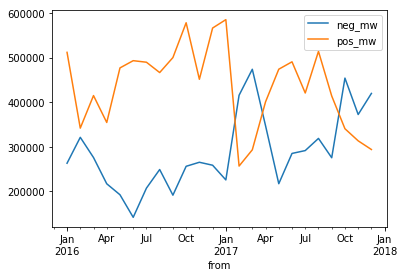

In [44]:
df_activated.set_index("from").groupby(pd.Grouper(freq='M')).sum().plot()

# Calculate Merit order for each Week

In [239]:
# Use index and then resample
# https://stackoverflow.com/questions/29706740/grouping-pandas-data-frame-by-time-intervals